In [1]:
# All imports
from glob import glob
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np

__DEBUG__= False

In [2]:
# Function for performing camera calibraation

def calibrate_camera(calib_img_dir,nb_x_corners,nb_y_corners):
    
    calib_img_paths = glob(calib_img_dir+'*.jpg')

    # Object points are 3-D integral coordinates of all internal corners
    # in a Chessboard image. The z coordinates are all zero.

    # The object points matrix has as many columns as there are x positions
    # and as many rows as there are y positions.

    x_coords,y_coords = np.meshgrid(range(nb_x_corners),range(nb_y_corners))
    z_coords = np.zeros(shape=[nb_y_corners,nb_x_corners])

    obj_points = np.dstack((x_coords,y_coords,z_coords))

    # Reshape the matrx of coordinates in to a list that has all coordinates
    # from left to right and top to bottom.
    obj_points = obj_points.reshape([-1,3])

    obj_points_list = []
    img_points_list = []

    detected = 0

    for path in tqdm(calib_img_paths):
        img = cv2.imread(path)
        grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grey,(nb_x_corners,nb_y_corners))

        if ret == True:
            if __DEBUG__:
                cv2.drawChessboardCorners(img,(nb_x_corners,nb_y_corners),corners,ret)
                plt.imshow(img)
                plt.show()

            obj_points_list.append(obj_points)
            img_points_list.append(corners)

            detected += 1
            
    # Reshape object points and image points as required by the new OpenCV interface
    obj_points_matrix = np.array(obj_points_list).reshape([detected,-1,3])
    img_points_matrix = np.array(img_points_list).reshape([detected,-1,2])
    
    # Perform actual calibration using our object points and 
    # image points found above.
    test_img = cv2.imread('camera_cal/calibration1.jpg')
    retval, cameraMatrix, distCoeffs, rvecs, tvecs =\
    cv2.calibrateCamera(obj_points_matrix.astype(np.float32),
                        img_points_matrix.astype(np.float32),
                        (test_img.shape[1],test_img.shape[0]),
                        None,
                        None)
    
    return retval, cameraMatrix, distCoeffs, rvecs, tvecs

In [3]:
# Camera calibration.

calib_img_dir = './camera_cal/'

# Number of internal corners in the calibration images.
# Obtained by manual inspection.
nb_x_corners = 9
nb_y_corners = 6

retval, cameraMatrix, distCoeffs, rvecs, tvecs = calibrate_camera(calib_img_dir,nb_x_corners,nb_y_corners)

100%|██████████| 20/20 [00:05<00:00,  5.39it/s]


In [4]:
def plot_many(imgs,titles,shape,cmaps=None,figsize=(24,9)):
    
    assert len(imgs) == len(titles) and len(imgs) == shape[0]*shape[1]
    
    fig, axes = plt.subplots(shape[0],shape[1],figsize=figsize)
    axes = axes.flatten()
    
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i],cmap=cmaps[i] if cmaps is not None else None)
        axes[i].set_title(titles[i])

    plt.show()

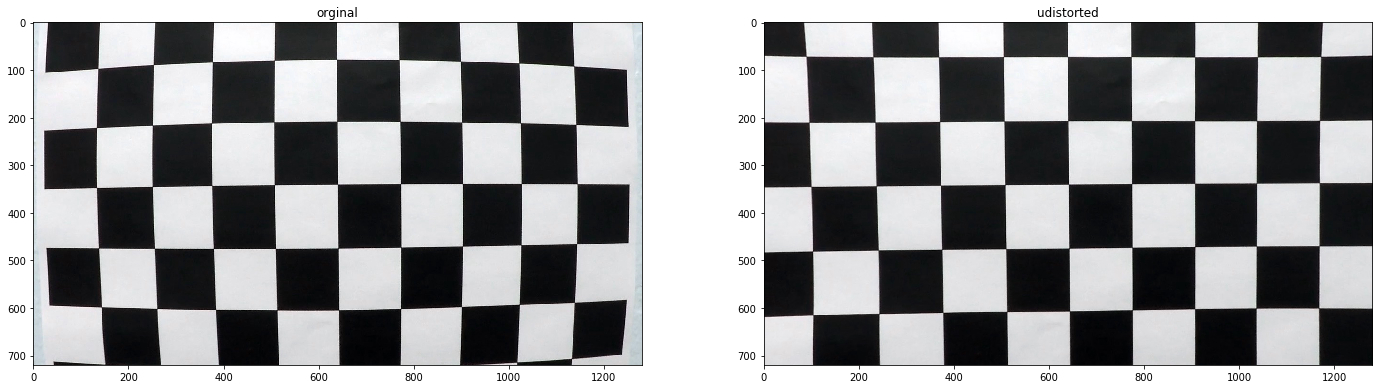

In [5]:
# Test distortion correction.
def test_undistortion(img_path):
    test_img = cv2.imread(img_path)
    undistorted = cv2.undistort(test_img,cameraMatrix,distCoeffs)
    plot_many([test_img,undistorted],['orginal','udistorted'],[1,2])
    
test_undistortion('camera_cal/calibration1.jpg')


In [6]:
def get_abs_sobel_mask(img, orient='x', kernel=3, thresh=(0,255)):
    
    grey  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    elif orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    else:
        raise Exception("Invalid orientation {}".format(x))
     
    scaled_abs_sobel = (255. * abs_sobel / np.max(abs_sobel)).astype(np.uint8)
    
    binary_mask = np.logical_and(abs_sobel >= thresh[0], abs_sobel <= thresh[1] )
    
    return binary_mask.astype(np.uint8)

In [7]:
def get_mag_sobel_mask(img, kernel=3, mag_thresh=(0,255)):
    
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    abs_sobel_x = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    abs_soble_y = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    abs_sobel_mag = np.sqrt(abs_sobel_x**2+abs_soble_y**2)
    
    scaled_abs_sobel_mag = (abs_sobel_mag * 255.0 / np.max(abs_sobel_mag)).astype(np.uint8)
    
    binary_mask = np.logical_and(scaled_abs_sobel_mag >= mag_thresh[0], 
                                 scaled_abs_sobel_mag <= mag_thresh[1])
    
    return binary_mask.astype(np.uint8)

In [8]:
def get_ang_sobel_mask(img, kernel=3, ang_thresh=(0,np.pi/2.)):
    
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    abs_sobel_x = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    abs_soble_y = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    
    
    abs_sobel_angle = np.arctan2(abs_soble_y,abs_sobel_x)
    
    
    binary_mask = np.logical_and(abs_sobel_angle >= ang_thresh[0], 
                                 abs_sobel_angle <= ang_thresh[1])
    
    return binary_mask.astype(np.uint8)

In [9]:
# Combine masks
def combine_masks(mask_a,mask_b,comb_fn):
    return comb_fn(mask_a,mask_b).astype(np.uint8)

In [10]:
def get_sobel_masks(img,mask_names=['x','y','mag','ang']):
   
    masks = []
    if 'x' in mask_names:
        x_mask = get_abs_sobel_mask(img,orient='x',kernel=3,thresh=(50,180))
        masks.append(x_mask)
    
    if 'y' in mask_names:
        y_mask = get_abs_sobel_mask(img,orient='y',kernel=3,thresh=(50,180))
        masks.append(y_mask)
        
    if 'mag' in mask_names:
        mag_mask = get_mag_sobel_mask(img,kernel=3,mag_thresh=(80,150))
        masks.append(mag_mask)
        
    if 'ang' in mask_names:
        ang_mask = get_ang_sobel_mask(img,kernel=15,ang_thresh=(0.85,1.0))
        masks.append(ang_mask)
    
    return masks
    

In [11]:
def get_channel_mask_fn(chan_name:str):
    ''' 
    Returns a function that can be used to generate a binary mask from an BGR or HSV image.
    The function returned s configured based on the channel_name passed here.
    if the chan_name argument is 'h', 's' or 'v', automatic olorspace conversion would be done
    by the returned function.
    '''

    
    name_to_index = { 'b':0, 'g':1, 'r':2, 'h':0, 'l':1, 's':2}
    
    if chan_name not in name_to_index.keys():
        raise Exception('{} chan_name is not a valid chanel name'.format(chan_name))
        
    def no_conversion(img):
        return img
        
    color_scheme_converson_fn = lambda img: no_conversion(img) if chan_name in ['b','g','r'] else cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    
    def _f(img,thresh=(0,255)):
        '''
        img: BGR or HSV image.Performs automatic colorspace conversion if needed.
        '''
        img_converted = color_scheme_converson_fn(img)
        channel = img_converted[:,:,name_to_index[chan_name]]
        binary_mask = (np.logical_and(channel >= thresh[0], channel <= thresh[1])).astype(np.uint8)
    
        return binary_mask
    
    return _f

In [12]:
# Visulaize individual and combined sobel masks for all test images.
def visualize_mask_candidates(img_paths,group=0):

    s_mask_fn = get_channel_mask_fn('s')
    h_mask_fn = get_channel_mask_fn('h')
    l_mask_fn = get_channel_mask_fn('l')

    for path in img_paths:
        img_bgr = cv2.imread(path)

        [x_mask,y_mask,mag_mask,ang_mask] = get_sobel_masks(img_bgr)
        x_y_mask = combine_masks(x_mask,y_mask,np.logical_and)
        mag_ang_mask = combine_masks(mag_mask,ang_mask,np.logical_and)

        all_mask1 = combine_masks(x_y_mask,mag_ang_mask,np.logical_or)

        s_mask = s_mask_fn(img_bgr,thresh=(170,255))

        x_s_mask = combine_masks(x_mask,s_mask,np.logical_or)
        y_s_mask = combine_masks(y_mask,s_mask,np.logical_and)
        x_y_s_mask = combine_masks(x_s_mask,y_s_mask,np.logical_and)

        mag_s_mask = combine_masks(mag_mask,s_mask,np.logical_or)
        ang_s_mask = combine_masks(ang_mask,s_mask,np.logical_and)
        mag_ang_s_mask = combine_masks(mag_s_mask,ang_s_mask,np.logical_or)

        all_mask2 = combine_masks(x_y_s_mask,mag_ang_s_mask,np.logical_or)

        rgb_img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    
        if group == 0:
            plot_many([rgb_img,x_mask,y_mask,x_y_mask,
                       mag_mask,ang_mask,mag_ang_mask,all_mask1,
                       s_mask,x_s_mask,y_s_mask,x_y_s_mask,
                       mag_s_mask,ang_s_mask,mag_ang_s_mask,all_mask2],
                      ['original','x','y','(x&y)',
                       'magnitude','angle','(mag&ang)','All1',
                       's','(s|x)','(s|y)','(s|x) & (s|y)', 
                       '(s|mag)','(s&ang)','((s|mag) |(s&ang))','All2'],
                      [4,4],figsize=(24,18))
            
        elif group == 1:

            plot_many([rgb_img,x_s_mask,mag_s_mask,
                       ang_s_mask,(x_s_mask|mag_s_mask|ang_s_mask),((s_mask&x_mask)|(s_mask&y_mask)|mag_mask|s_mask&ang_mask)],
                      ['original','(s|x)','(s|mag)',
                       '(s&ang)','(s|x)| (s|mag)|(s&ang)','((s&x)|(s&y))|mag|(s&ang)'],
                      [2,3])
            
        elif group == 2:
            plot_many([rgb_img,mag_ang_s_mask],
                      ['original','(s|mag)|(s&ang)'],
                      [1,2])


visualize_mask_candidates(glob('bad_frames/*.png'),0)

In [13]:
def get_lane_mask(img_bgr):
    mag_mask,ang_mask = get_sobel_masks(img_bgr,['mag','ang'])
    
    get_s_mask = get_channel_mask_fn('s')
    get_l_mask = get_channel_mask_fn('l')
    
    s_mask = get_s_mask(img_bgr,thresh=(170,255))
    l_mask = get_l_mask(img_bgr,thresh=(0,20))
    
    
    mag_s_mask = combine_masks(mag_mask,s_mask,np.logical_or)
    ang_s_mask = combine_masks(ang_mask,s_mask,np.logical_and)
    mag_ang_s_mask = combine_masks(mag_s_mask,ang_s_mask,np.logical_or)
    
    return mag_ang_s_mask & (~l_mask)

In [14]:
def draw_polygon(img,pts,color=[255,0,0],thickness=5,isClosed=True):
    n = len(pts)
    try:
        for i in range(n-1):
            cv2.line(img,pts[i],pts[i+1],color,thickness) 

        if isClosed == True:
            cv2.line(img,pts[n-1],pts[(0)],color,thickness)
    except :
        print("Error trying to draw line {} {}".format(pts[i],pts[i+1]))
        raise 

In [15]:
def overlay_polygon(img,pts,alpha=1.,beta=1.,gamma=0.):
    overlay = np.zeros_like(img)    
    draw_polygon(overlay,pts)
    return cv2.addWeighted(img,alpha,overlay,beta,gamma)

In [16]:
def get_persprective_transforms(src_points, dst_points):
    M = cv2.getPerspectiveTransform(np.float32(src_points),np.float32(dst_points))
    Minv = cv2.getPerspectiveTransform(np.float32(dst_points),np.float32(src_points))
    
    return M,Minv

In [17]:
def warp(img,M):
    img_size = img_size = (img.shape[1],img.shape[0])
    return cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    

In [18]:
# Reference image.
perspective_ref_img_path = 'test_images/straight_lines1.jpg'
# Points seleted by manual inspetion of reference path.
perspective_src_points = [(203,720),(1099,720),(707,463),(580,463)]
perspective_dst_points = [(203,720),(1099,720),(1099,0),(203,0)]


# Find and apply perspective transform.
M,Minv = get_persprective_transforms(perspective_src_points,perspective_dst_points)

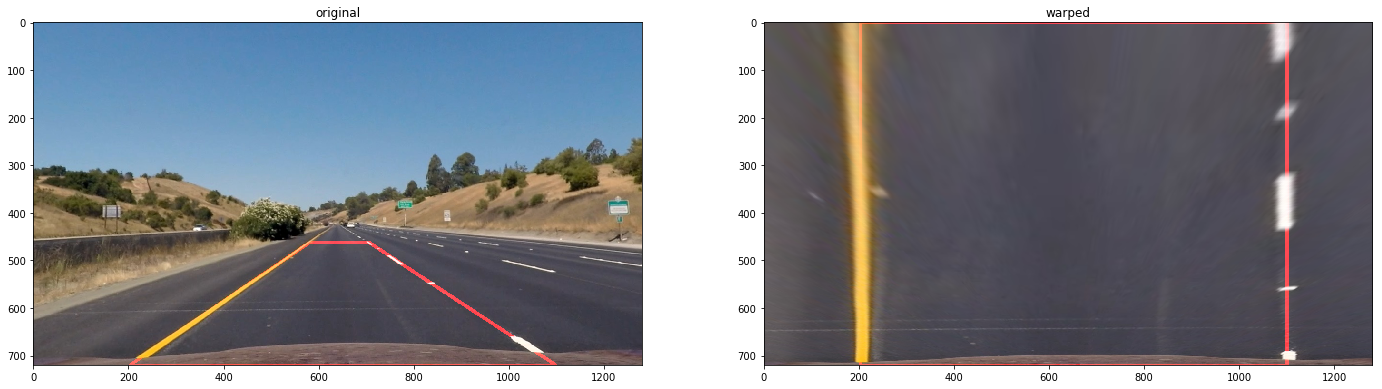

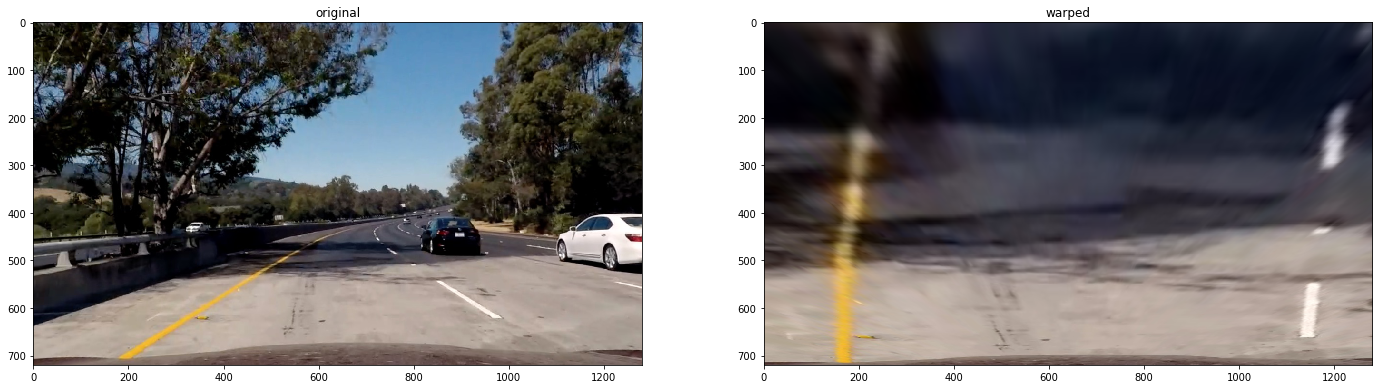

In [19]:
## Setup and test perspective transform.
def test_perspective_transform(ref_img_path,test_img_path,src_points,dst_points):
    # Load image of straight lane lines and apply undistortion.
    img_straight_bgr = cv2.imread(ref_img_path)
    img_straight_bgr = cv2.undistort(img_straight_bgr,cameraMatrix,distCoeffs)
    img_straight_rgb = cv2.cvtColor(img_straight_bgr,cv2.COLOR_BGR2RGB)


    img_straight_rgb_warped = warp(img_straight_rgb,M)

    # Test on train image
    plot_many([overlay_polygon(img_straight_rgb,src_points),overlay_polygon(img_straight_rgb_warped,dst_points)],
              ['original','warped'],
              [1,2])

    # Test on curved lane image
    curved_image = cv2.cvtColor(cv2.imread(test_img_path),cv2.COLOR_BGR2RGB)
    curved_image = cv2.undistort(curved_image,cameraMatrix,distCoeffs)
    transformed_image = warp(curved_image,M)
    plot_many([curved_image,transformed_image],['original','warped'],[1,2])
    
    
test_perspective_transform(perspective_ref_img_path,'test_images/test5.jpg',perspective_src_points,perspective_dst_points)


In [20]:
def find_lanes(binary_image, debug=False):

    if debug == True:
        debug_img = np.dstack((binary_image,binary_image,binary_image)) * 255
    
    # Windowed search params.
    nb_windows = 9
    window_half_width = 100
    
    # nonzero() returns row and column indices
    # convert to x and y coordinates.
    nonzero_y = np.nonzero(binary_image)[0]
    nonzero_x = np.nonzero(binary_image)[1]
    
    recenter_threshold = 50

    
    def find_lane_bases():
        # Find hot columns in the lower half of the image.
        mid_row = np.int(binary_image.shape[0] / 2)
        histogram = np.sum(binary_image[mid_row:,:],axis=0)

        mid_col = np.int(histogram.shape[0] / 2)

        # Return indices of hottest columns in the left and right halves. 
        return np.argmax(histogram[:mid_col]), mid_col + np.argmax(histogram[mid_col:])

    
    def search_lane(x_center,hot_pixel_color=None):
        window_height = np.int(binary_image.shape[0]/nb_windows)
        
        search_window_corners = []
        lane_x_coordintes = []
        lane_y_coordintes = []
        
        for i in range(nb_windows):
            window_x_lo = x_center - window_half_width
            window_x_hi = x_center + window_half_width
            
            # Height is number of rows in image matrix and y coordinate increases
            # from bottom to top so y_lo is the numerically lower, top extent of 
            # the window and y_hi is the numerically higher, bottom extent of the
            # window.
            window_y_lo = binary_image.shape[0] - (i+1)*window_height
            window_y_hi = window_y_lo + window_height
            
            # Add window coordintes to list.
            search_window_corners.append([(window_x_lo,window_y_lo),(window_x_hi,window_y_hi)])
            
            # Find 'ON' pixels that lie within the current window.
            is_on = ( (nonzero_x >= window_x_lo) & (nonzero_x <= window_x_hi) ) &\
                    ( (nonzero_y >= window_y_lo) & (nonzero_y <= window_y_hi) )
                
            on_x = nonzero_x[is_on]
            on_y = nonzero_y[is_on]
            
            if debug == True:
                debug_img[on_y,on_x,:] = hot_pixel_color
                cv2.rectangle(debug_img,(window_x_lo,window_y_lo),(window_x_hi,window_y_hi),[0,0,255],5)
            
            lane_x_coordintes.append(on_x)
            lane_y_coordintes.append(on_y)
            
            # If 'ON' pixel count is above threshold, recenter the window (horizontally).
            if np.sum(is_on) >= recenter_threshold:
                x_center = np.int(np.mean(on_x))

            
        
        lane_x_coordintes = np.concatenate(lane_x_coordintes)
        lane_y_coordintes = np.concatenate(lane_y_coordintes)
        
        return search_window_corners,(lane_x_coordintes,lane_y_coordintes)
    
    
    
    left_lane_base_x, right_lane_base_x = find_lane_bases()
    left_lane_info = search_lane(left_lane_base_x,hot_pixel_color=[255,0,0])
    right_lane_info = search_lane(right_lane_base_x,hot_pixel_color=[0,255,0])
    
    if debug == True:
        plt.imshow(debug_img)
        plt.show()
    
    return left_lane_info,right_lane_info
                
   

In [21]:
def fit_poly_to_lane(x_pts,y_pts):
    return np.polyfit(y_pts,x_pts,2)

In [22]:
def eval_qudratic(coeffs,pts):
    return (coeffs[0] * pts**2 + coeffs[1] * pts + coeffs[2]).astype(np.uint32)

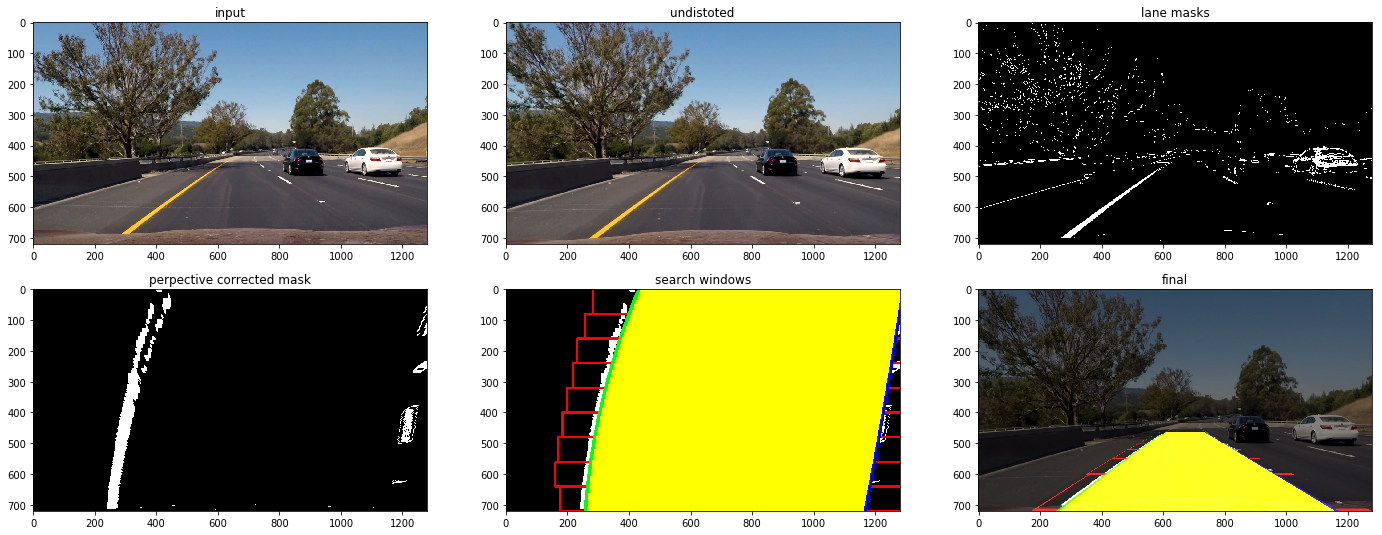

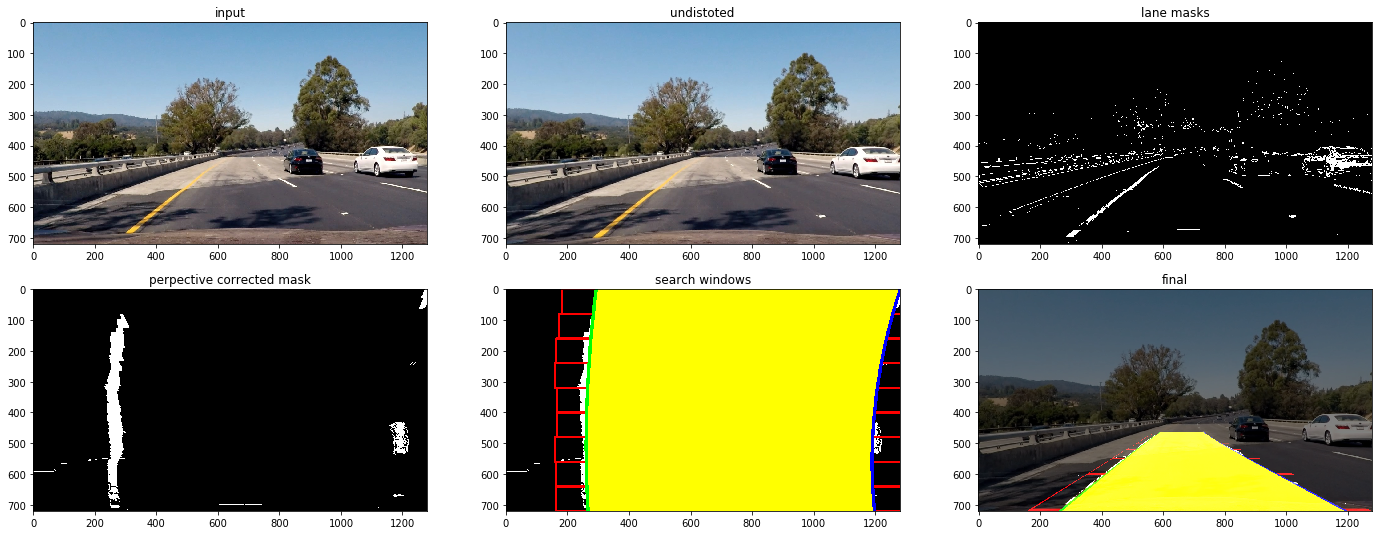

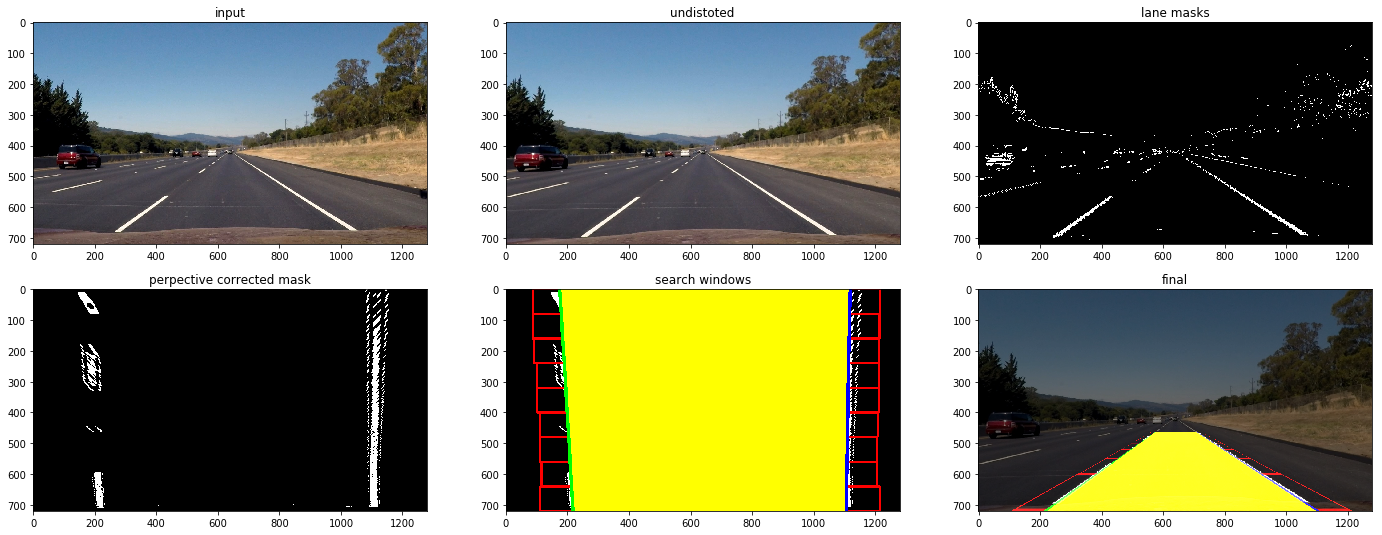

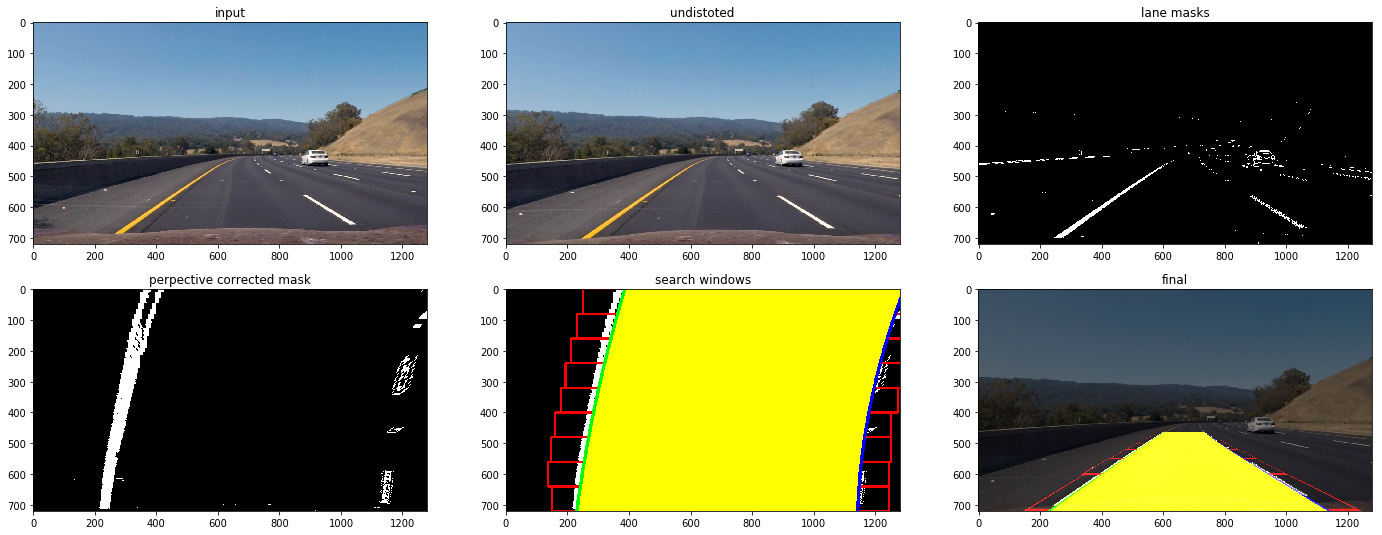

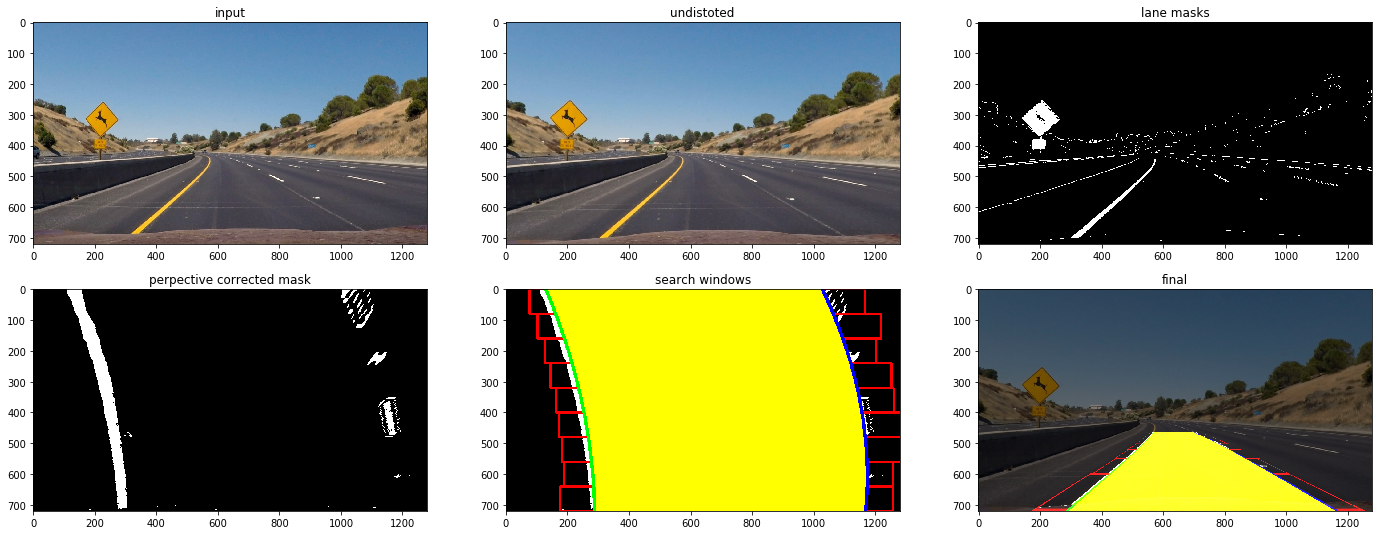

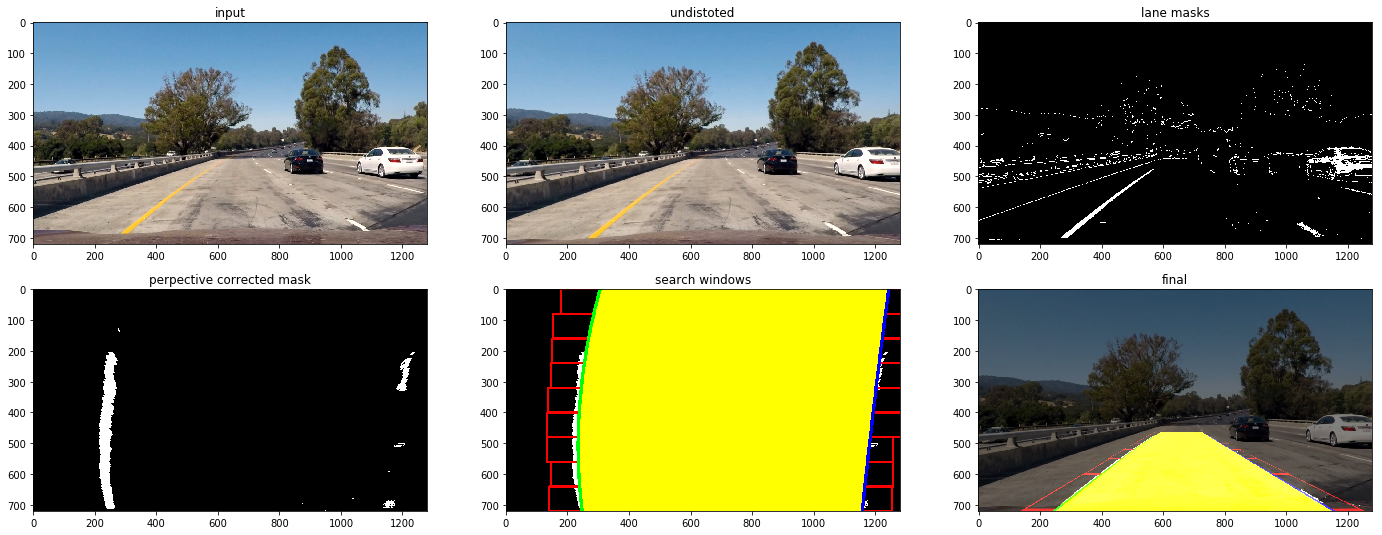

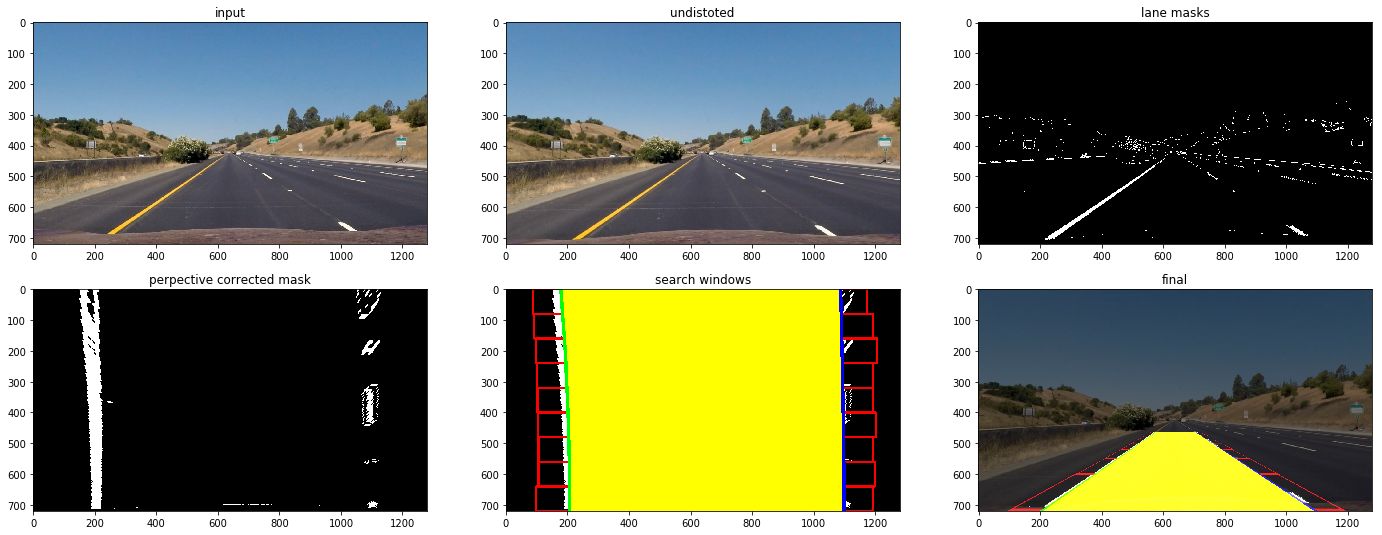

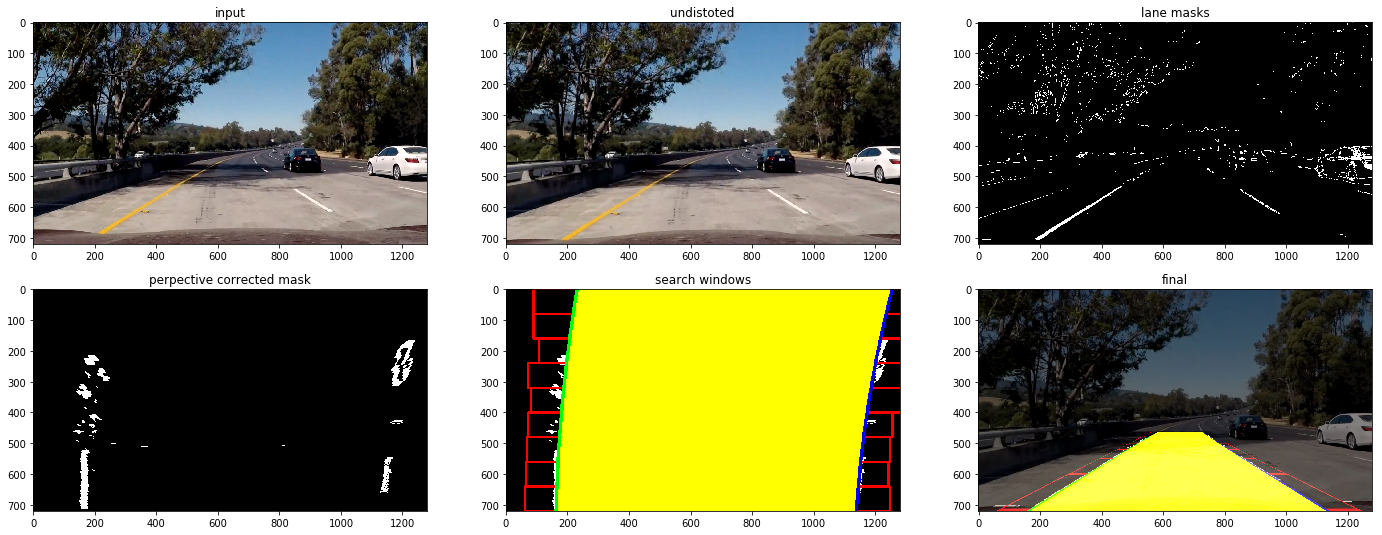

In [74]:
def test_lane_detection(img_bgr_path):
    test_img_bgr = cv2.imread(img_bgr_path)
    test_img_rgb = cv2.cvtColor(test_img_bgr,cv2.COLOR_BGR2RGB)
    
    undistort_bgr = cv2.undistort(test_img_bgr,cameraMatrix,distCoeffs)
    undistort_rgb = cv2.cvtColor(undistort_bgr,cv2.COLOR_BGR2RGB)
    binary_image = get_lane_mask(undistort_bgr)
    
    perspective_corrected = warp(binary_image,M) 
    
    left_lane_info,right_lane_info = find_lanes(perspective_corrected)
    
    left_lane_windows = left_lane_info[0]
    right_lane_windows = right_lane_info[0]
    
    left_lane_x,left_lane_y = left_lane_info[1]
    right_lane_x, right_lane_y = right_lane_info[1]
    
    left_poly = fit_poly_to_lane(left_lane_x,left_lane_y)
    right_poly = fit_poly_to_lane(right_lane_x,right_lane_y)
    
    ys = np.array(range(perspective_corrected.shape[0]),dtype=np.int32)
    xs_left  = eval_qudratic(left_poly,ys)
    xs_right = eval_qudratic(right_poly,ys)
  
    search_area_img = np.dstack((perspective_corrected,perspective_corrected,perspective_corrected)) * 255
    
    for window in left_lane_windows:
        cv2.rectangle(search_area_img,window[0],window[1],color=[255,0,0],thickness=5)
    
    for window in right_lane_windows:
        cv2.rectangle(search_area_img,window[0],window[1],color=[255,0,0],thickness=5)
     
    left_points = [(x,y) for (x,y) in zip(xs_left,ys)]
    right_points  = [(x,y) for (x,y) in zip(xs_right,ys)]
    all_points = [pt for pt in left_points]
    all_points.extend([pt for pt in reversed(right_points)])
       
    cv2.fillPoly(search_area_img,np.array([all_points],dtype = np.int32),[255,255,0])
    draw_polygon(search_area_img,left_points,color=[0,255,0],isClosed=False,thickness=10)
    draw_polygon(search_area_img,right_points,color=[0,0,255],isClosed=False,thickness=10)
    
    # Unwarp
    unwarp = warp(search_area_img,Minv)
    final = cv2.addWeighted(undistort_rgb,0.5,unwarp,1.0,0.0)
               
    plot_many([test_img_rgb,undistort_rgb,binary_image,perspective_corrected,search_area_img,final],
          ['input','undistoted','lane masks','perpective corrected mask','search windows','final'],
          [2,3],
          [None,None,'gray','gray',None,None]) 
    

for path in glob('test_images/*.jpg'):
    test_lane_detection(path)   

In [80]:
def draw_lanes(img):
    undistorted = cv2.undistort(img,cameraMatrix,distCoeffs)
    binary_image = get_lane_mask(undistorted)
    
    perspective_corrected = warp(binary_image,M) 
    
    left_lane_info,right_lane_info = find_lanes(perspective_corrected)
    
    left_lane_windows = left_lane_info[0]
    right_lane_windows = right_lane_info[0]
    
    left_lane_x,left_lane_y = left_lane_info[1]
    right_lane_x, right_lane_y = right_lane_info[1]
    
    left_poly = fit_poly_to_lane(left_lane_x,left_lane_y)
    right_poly = fit_poly_to_lane(right_lane_x,right_lane_y)
    
    ys = np.array(range(perspective_corrected.shape[0]),dtype=np.int32)
    xs_left  = eval_qudratic(left_poly,ys)
    xs_right = eval_qudratic(right_poly,ys)
    
    overlay = np.dstack((perspective_corrected,perspective_corrected,perspective_corrected)) * 255
    
    left_pts = [(x,y) for (x,y) in zip(xs_left,ys)]
    right_pts = [(x,y) for (x,y) in zip(xs_right,ys)]
    all_pts = [pt for pt in left_pts]
    all_pts.extend([pt for pt in reversed(right_pts)])
    
    cv2.fillPoly(overlay,np.array([all_pts],dtype = np.int32),[255,255,0])
    draw_polygon(overlay,left_pts,color=[0,255,0],isClosed=False,thickness=30)
    draw_polygon(overlay,right_pts,color=[0,0,255],isClosed=False,thickness=30)
     
    unwarp = warp(overlay,Minv)
    final = cv2.addWeighted(undistorted,1.0,unwarp,0.3,0.0)
    
    return final
    
    

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
from tqdm import tqdm

in_clip = VideoFileClip('project_video.mp4')

out_filename = 'processed-project_video.mp4'
out_clip = in_clip.fl_image(draw_lanes)

out_clip.write_videofile(out_filename,audio=False)
    


[MoviePy] >>>> Building video processed-project_video.mp4
[MoviePy] Writing video processed-project_video.mp4


 44%|████▍     | 556/1261 [03:59<04:59,  2.35it/s]

In [89]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
from tqdm import tqdm

in_clip = VideoFileClip('challenge_video.mp4')
nframe = int(in_clip.fps * in_clip.duration)

for i in tqdm(range(nframe)):
    image = in_clip.get_frame(i/in_clip.fps)
    name = "frame %f.png"  %(i/in_clip.fps)
    
    if os.path.isfile('frames1/'+name):
        #continue
        pass
    
    try:
        image_out = draw_lanes(image)
        plt.imsave('frames/'+name,image_out)
        
    except:
        plt.imsave('bad_frames1/'+name,image)
        
    # plt.imshow(image_out)
    
    # plt.show()
    


100%|██████████| 1260/1260 [30:31<00:00,  1.56s/it]


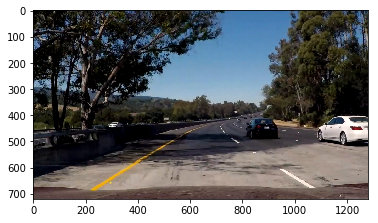

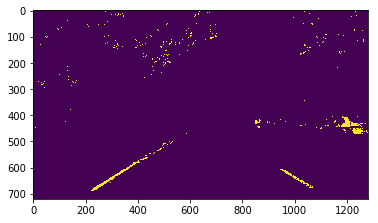

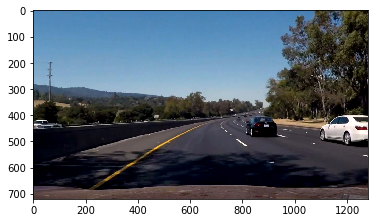

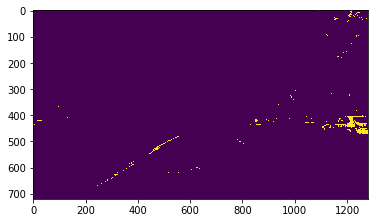

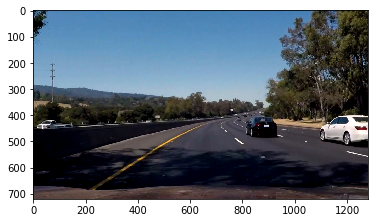

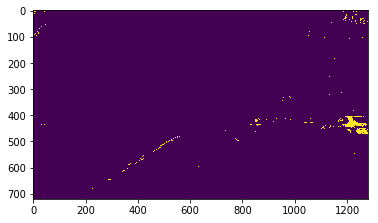

In [85]:
l_mas_gen = get_channel_mask_fn('l')
s_mas_gen = get_channel_mask_fn('s')

for path in glob('bad_frames/*.png'):
    image = cv2.imread(path)
#     out_image = draw_lanes(image)
    
#     plt.show(out_image)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(s_mas_gen(image,(170,255)) & (~l_mas_gen(image,thresh=(0,20))))
    plt.show()
    

In [57]:
a=[1,2,3]
b = a
b.append([4,5])
a
c = [ i for i in reversed(b)]
c

[[4, 5], 3, 2, 1]